In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd


# 베이스 경로 설정
BASE_DIR = '/content/drive/MyDrive/Dacon_FakeText/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import os
from tqdm import tqdm

In [ ]:
# Test 데이터 임베딩 로드
X_test = np.load(BASE_DIR + 'data/embeddings/test_concat.npy')
print(f"Test 임베딩 Shape: {X_test.shape}")

# Test 메타 정보 로드 (ID 필요)
test_df = pd.read_csv(BASE_DIR + 'data/test.csv')
test_ids = test_df['ID'].values

✅ Test 임베딩 Shape: (1962, 775)


In [ ]:
# MLP 모델 클래스 (학습 때 사용한 구조와 완전 동일해야 함)
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_folds = 5

X_test = X_test.astype(np.float32)
fold_preds = []

print("\nFold별 Test 예측 시작...")

# Fold별 모델 불러와서 예측
for fold in range(1, n_folds + 1):
    print(f"\n=== Fold {fold} 모델 예측 중 ===")

    model = MLP(input_dim=X_test.shape[1]).to(device)
    model_path = BASE_DIR + f'model/mlp_bce/mlp_fold{fold}.pt'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    preds = []
    with torch.no_grad():
        for i in range(0, len(X_test), 1024):  # Test 배치사이즈 조정 가능 (ex: 512~2048)
            batch_x = torch.tensor(X_test[i:i+1024], dtype=torch.float32).to(device)
            batch_pred = model(batch_x).squeeze().cpu().numpy()
            preds.extend(batch_pred)

    fold_preds.append(np.array(preds))
    print(f"Fold {fold} 예측 완료! Shape: {len(preds)}")



✅ Fold별 Test 예측 시작...

=== Fold 1 모델 예측 중 ===
✅ Fold 1 예측 완료! Shape: 1962

=== Fold 2 모델 예측 중 ===
✅ Fold 2 예측 완료! Shape: 1962

=== Fold 3 모델 예측 중 ===
✅ Fold 3 예측 완료! Shape: 1962

=== Fold 4 모델 예측 중 ===
✅ Fold 4 예측 완료! Shape: 1962

=== Fold 5 모델 예측 중 ===
✅ Fold 5 예측 완료! Shape: 1962


In [ ]:


# Fold별 예측값 평균 (앙상블)
final_preds = np.mean(fold_preds, axis=0)
print(f"\n최종 앙상블 예측 완료! Shape: {final_preds.shape}")


# 제출파일 생성
submission = pd.DataFrame({
    'ID': test_ids,
    'generated': final_preds
})

output_path = BASE_DIR + '/output/concat_deep_mlp_5.csv'
submission.to_csv(output_path, index=False, encoding='utf-8')
print(f"\n제출파일 저장 완료: {output_path}")


✅ 최종 앙상블 예측 완료! Shape: (1962,)

✅ 제출파일 저장 완료: /content/drive/MyDrive/Dacon_FakeText//output/concat_deep_mlp_5.csv


✅ X_train shape: (1226364, 905)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


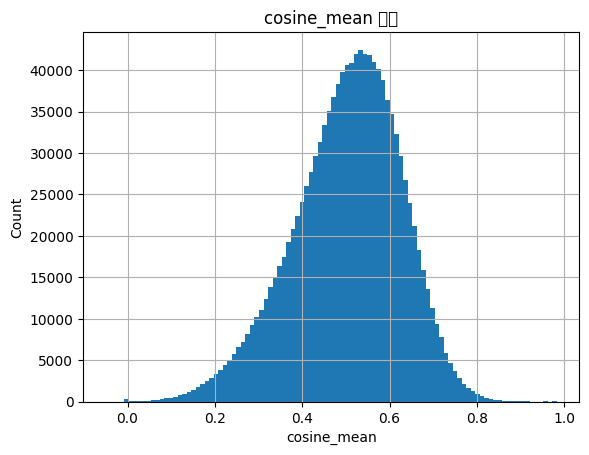

In [ ]:
import matplotlib.pyplot as plt
X_train = np.load(BASE_DIR + 'data/embeddings/train_concat_full.npy')
print(f"X_train shape: {X_train.shape}")  # 예: (1226364, 905)
train_df = pd.read_parquet(BASE_DIR + 'data/train_paragraph_1.parquet')

plt.hist(train_df['cosine_mean'], bins=100)
plt.title('cosine_mean 분포')
plt.xlabel('cosine_mean')
plt.ylabel('Count')
plt.grid(True)
plt.show()